In [0]:
data = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv')
from datetime import datetime as dt
dt.strftime(dt.strptime(data['data'].iloc[0], "%Y-%m-%dT%H:%M:%S"), "%d-%m")
#data
#data.unstack(level='data')
#data.pivot(index='denominazione_provincia', columns='data', values='totale_casi')
#@title Nuovi contagi giornalieri in Italia
!pip install googledrivedownloader
from google_drive_downloader import GoogleDriveDownloader
GoogleDriveDownloader.download_file_from_google_drive(file_id='1tU_MRukrg3D2iZFZ-tk4oj6MfV4o7q4u',
                                                      dest_path='./rilevazioni.csv', overwrite=True)
import os
import requests
import pandas as pd
import random
import numpy as np
rilevazioni = pd.read_csv('rilevazioni.csv').set_index(['Regione','Citta'])
rilevazioni.iloc[:,-10:]
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

def plot_annotate(df, title='', xdelta=0, ydelta=10, figsize=(17, 7)):
  
  ax = df.T.plot(figsize=figsize, title=title)
  ax.set_xticks(ticks=np.arange(0, len(df.columns) , step=2))
  tick_label = list(df.columns)[::2]
  ax.set_xticklabels(tick_label)

  for k, v in zip(np.arange(len(df.columns)), df.T.iterrows()):
    for el in v[1]:
      ax.annotate(el, (k + xdelta, el + ydelta))
  return ax

sorted_by_infections = rilevazioni.loc[rilevazioni.sort_values(by=[rilevazioni.columns[-1]],ascending=False).index]
crescita = pd.DataFrame(index=sorted_by_infections.index)
for ieri, oggi in zip(sorted_by_infections.columns[:-1], sorted_by_infections.columns[1:]):
  crescita[oggi] = sorted_by_infections[oggi] - sorted_by_infections[ieri]
# display(crescita.head(3))
sorted_by_infections.head(3)
crescita_italia = crescita.sum().to_frame().T
crescita_italia.index = ['Italia']
_ = plot_annotate(crescita_italia, 'Cresciata giornaliera di contagi sull\'intero territorio Italiano')

In [47]:
crescita.head()

09-03  10-03  11-03  12-03  ...  25-04  26-04  27-04  28-04
Regione   Citta                                ...                            
LOMBARDIA MILANO     100     86    333    221  ...    219    463    188    278
          BRESCIA    238     51    561    247  ...     65     24     35     92
PIEMONTE  TORINO      -2     24     48     28  ...    321    263    125    240
LOMBARDIA BERGAMO    248    227    343    321  ...     45     66     37     46
          CREMONA    251     41    104    241  ...     39     60      5     22

[5 rows x 51 columns]

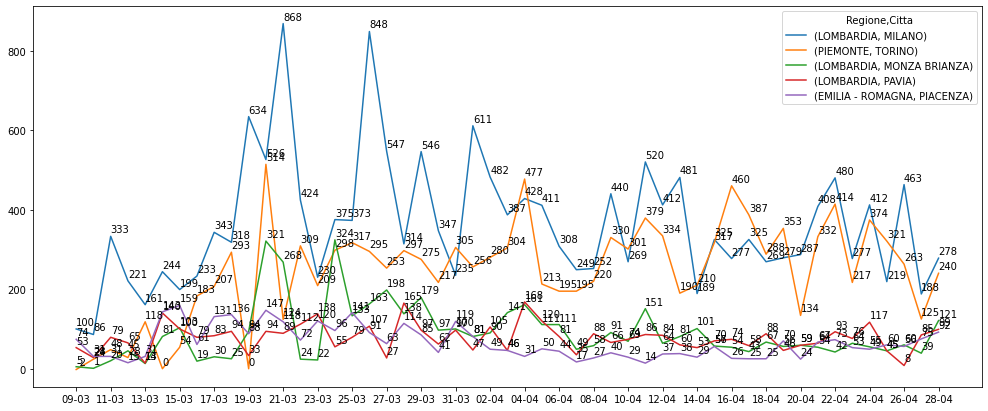

In [27]:
#@title Crescita giornaliere di contagi per le province con maggior crescita
ax = plot_annotate(crescita.sort_values(by=crescita.columns[-1], ascending=False).head(5))
#_ = ax.set_ylim(-111,ax.get_ylim()[1])

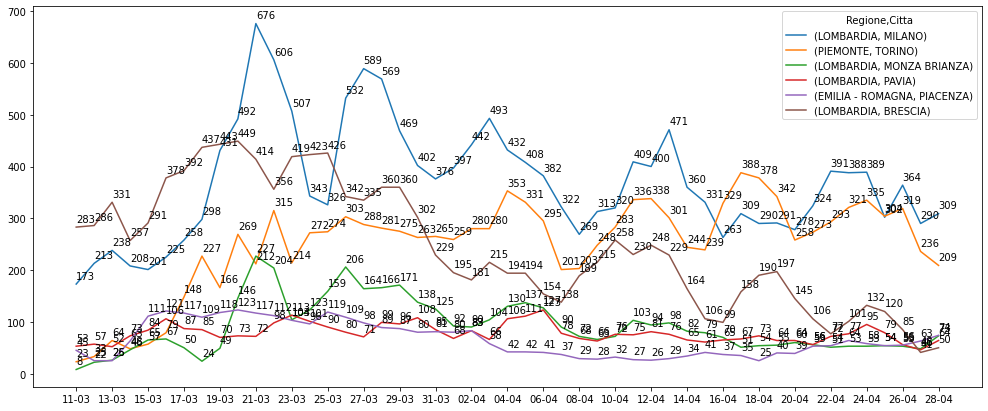

In [28]:
#@title Crescita giornaliera di contagi mediata su un intervallo di 3 giorni per le province con maggior crescita
avg3 = pd.DataFrame(index=crescita.sort_values(by=crescita.columns[-1], ascending=False).index)
for meno2,ieri, oggi in zip(crescita.columns[:-2], crescita.columns[1:-1], crescita.columns[2:]):
  avg3[oggi] = pd.concat([crescita[oggi], crescita[ieri], crescita[meno2]], axis=1).mean(axis=1)
avg3 = avg3.astype('int32')
_ = plot_annotate(avg3.head(6))

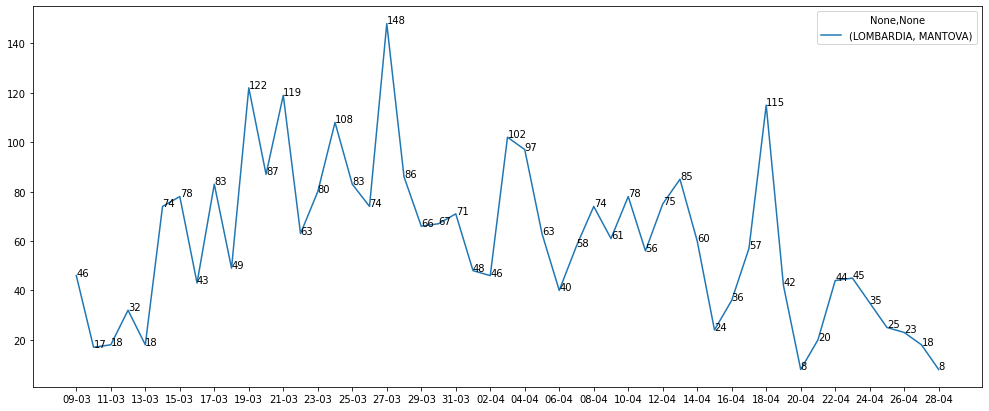

In [29]:
#@title Crescita giornaliera di contagi a Mantova
_ = plot_annotate(crescita.loc[('LOMBARDIA','MANTOVA')].to_frame().T, ydelta=0)

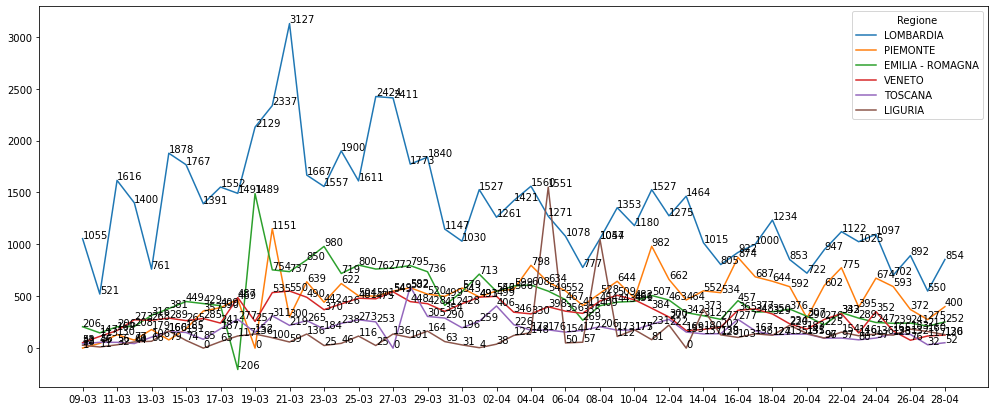

In [31]:
#@title Crescita giornaliera per le 5 regioni maggiormente infette
regioni = sorted_by_infections.groupby('Regione').sum()
regioni = regioni.sort_values(by=[regioni.columns[-1]],ascending=False)
crescita_regioni = crescita.groupby('Regione').sum().loc[regioni.index]
_ = plot_annotate(crescita_regioni.head(6))


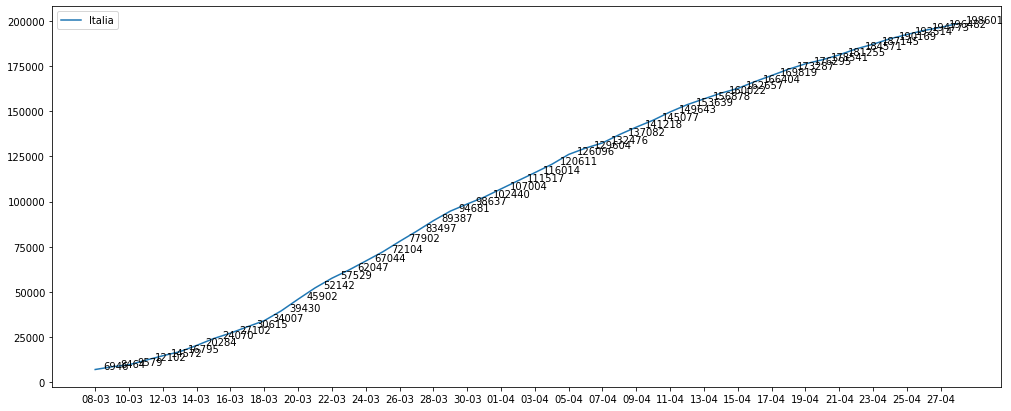

In [32]:
#@title Contagi totali in Italia
casi_italia = sorted_by_infections.sum(axis=0).to_frame().T
casi_italia.index= ['Italia']
_ = plot_annotate(casi_italia, xdelta=0.5)

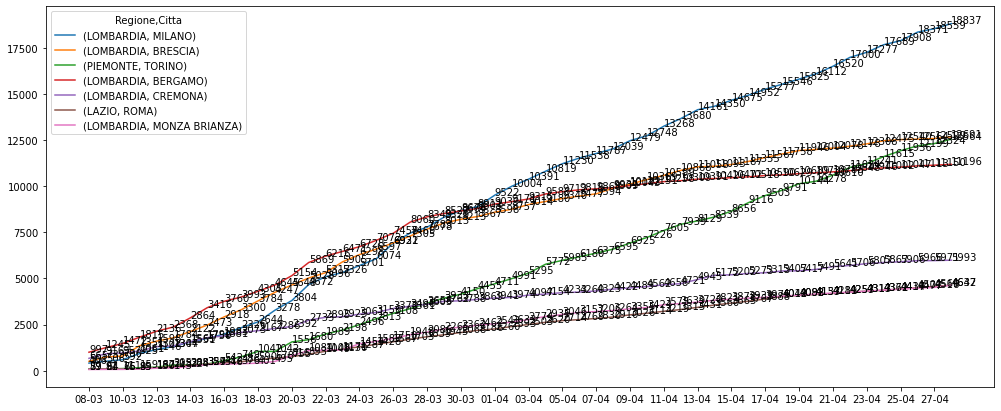

In [33]:
#@title Contagi totali per le province maggiormente infette
_ = plot_annotate(sorted_by_infections.head(7))

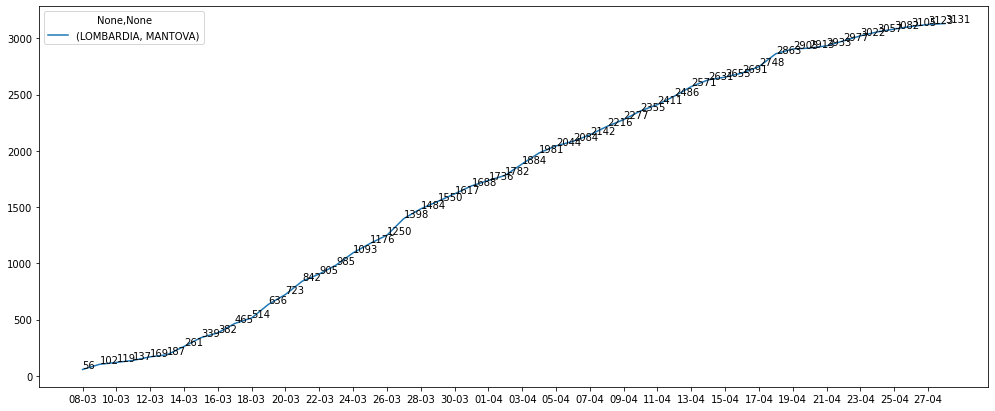

In [34]:
#@title Contagi totali a Mantova
_ = plot_annotate(sorted_by_infections.loc[('LOMBARDIA','MANTOVA')].to_frame().T)

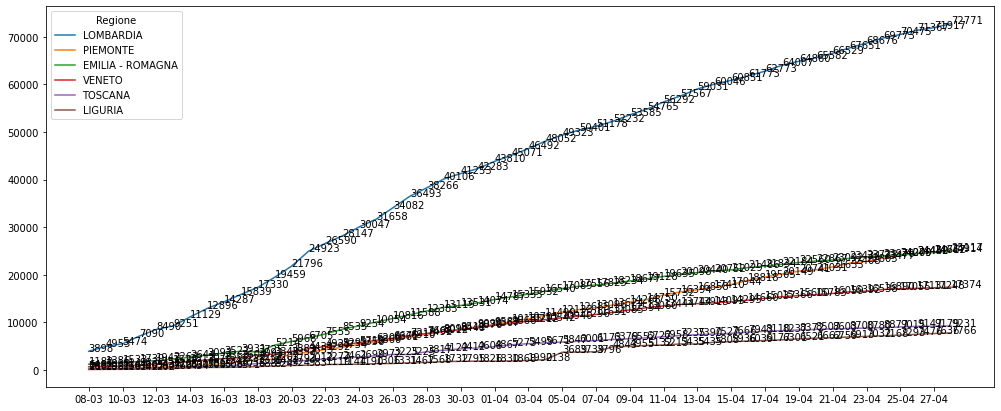

In [35]:
#@title Contagi totali regioni
_ = plot_annotate(regioni.head(6))